## E2E оценка + semantic wer

In [ ]:
import os
import json
import base64
from io import BytesIO
from pathlib import Path
from itertools import product
from typing import Dict, List

HF_CACHE_DIR = ""
os.environ["HF_HOME"] = HF_CACHE_DIR
os.environ["HUGGINGFACE_HUB_CACHE"] = HF_CACHE_DIR
os.environ["TRANSFORMERS_CACHE"] = HF_CACHE_DIR
os.environ["HF_DATASETS_CACHE"] = HF_CACHE_DIR
os.environ["DIFFUSERS_CACHE"] = HF_CACHE_DIR
os.environ["HF_HUB_CACHE"] = HF_CACHE_DIR
Path(HF_CACHE_DIR).mkdir(parents=True, exist_ok=True)
print(f"HF cache directory set to: {HF_CACHE_DIR}")

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import JsonOutputParser

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

HF cache directory set to: /data/sallundina/.cache/huggingface


/home/sallundina/envs/env_new3.11/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


DEVICE: cuda:1


In [2]:
ASR_TABLES = {
    "gigaam":   "vambassa/gigaam_inference",
    "tone":     "vambassa/t-one_inference",
    "parakeet": "vambassa/parakeet_inference",
}

MAX_EXAMPLES = 100
CACHE_DIR = Path("results_cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
dataset = load_dataset("arood0/mmm_project_with_audio_ru_final", split="train[:1000]")
df_img = dataset.to_pandas()

def to_pil(x):
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    if isinstance(x, dict) and "bytes" in x:
        return Image.open(BytesIO(x["bytes"])).convert("RGB")
    raise ValueError(f"Unknown image format: {type(x)}")

df_img = df_img[
    ["INPUT_IMG", "OUTPUT_IMG", "EDITING_INSTRUCTION_RU"]
].copy()

df_img["input_image"] = df_img["INPUT_IMG"].apply(to_pil)
df_img["reference_image"] = df_img["OUTPUT_IMG"].apply(to_pil)
df_img["gt_text"] = df_img["EDITING_INSTRUCTION_RU"]

In [4]:
df_img = df_img.head(MAX_EXAMPLES)
df_img 

,INPUT_IMG,OUTPUT_IMG,EDITING_INSTRUCTION_RU,input_image,reference_image,gt_text
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Пусть мальчик протянет руки.,<PIL.Image.Image image mode=RGB size=3648x3648...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть мальчик протянет руки.
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Заставь птицу сложить крылья.,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Заставь птицу сложить крылья.
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"Женщина поднимает правую руку, как будто поздо...",<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,"Женщина поднимает правую руку, как будто поздо..."
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Позволь девушке поиграть с волосами обеими рук...,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Позволь девушке поиграть с волосами обеими рук...
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Женщина в черной одежде протянула правую руку ...,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Женщина в черной одежде протянула правую руку ...
...,...,...,...,...,...,...
95,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Правая рука женщины в черном стоит за другой ж...,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Правая рука женщины в черном стоит за другой ж...
96,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Пусть девчонка откроет рот и улыбнется.,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка откроет рот и улыбнется.
97,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Пусть девчонка повернёт голову.,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка повернёт голову.
98,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Пусть девчонка пошевелит руками.,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка пошевелит руками.


In [5]:
def load_asr_table(path: str) -> pd.DataFrame:
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    if path.endswith(".csv"):
        return pd.read_csv(path)
    dataset = load_dataset(path)
    return dataset["train"].to_pandas()

asr_dfs: Dict[str, pd.Series] = {}

for asr_name, path in ASR_TABLES.items():
    df = load_asr_table(path)
    asr_dfs[asr_name] = df["hypothesis_raw"].astype(str)

In [19]:
data_df = df_img[["input_image", "reference_image", "EDITING_INSTRUCTION_RU"]].copy()

for asr_name, series in asr_dfs.items():
    data_df[asr_name] = series.values[:len(data_df)]

ASR_NAMES = list(asr_dfs.keys())
print("ASR_NAMES:", ASR_NAMES)
data_df

ASR_NAMES: ['gigaam', 'tone', 'parakeet']


,input_image,reference_image,EDITING_INSTRUCTION_RU,gigaam,tone,parakeet
0,<PIL.Image.Image image mode=RGB size=3648x3648...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть мальчик протянет руки.,пусть мальчик протянет руки.,пусть мальчик протянет руки,пусть мальчик протянет руки.
1,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Заставь птицу сложить крылья.,заставь птицу сложить крылья.,заставь птицу сложить крылья,заставь птицу сложить крылья.
2,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,"Женщина поднимает правую руку, как будто поздо...","женщина поднимает правую руку, как будто поздо...",женщина поднимает правую руку как будто поздор...,"женщина поднимает правую руку, как будто поздо..."
3,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Позволь девушке поиграть с волосами обеими рук...,позволь девушке поиграть с волосами обеими рук...,позволь девушке поиграть с волосами обеими руками,позволь девушке поиграть с волосами обеими рук...
4,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Женщина в черной одежде протянула правую руку ...,женщина в чёрной одежде протянула правую руку ...,женщина в черной одежде протянула правую руку ...,женщина в черной одежде протянула правую руку ...
...,...,...,...,...,...,...
95,<PIL.Image.Image image mode=RGB size=720x720 a...,<PIL.Image.Image image mode=RGB size=1024x1024...,Правая рука женщины в черном стоит за другой ж...,правая рука женщины в чёрном стоит за другой ж...,правая рука женщины в черном стоит за другой ж...,правая рука женщины в черном стоит за другой ж...
96,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка откроет рот и улыбнется.,пусть девчонка откроет рот и улыбнётся.,пусть девчонка откроет рот и улыбнется,пусть девчонка откроет рот и улыбнется.
97,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка повернёт голову.,пусть девчонка повернёт голову.,пусть девчонка повернет голову,пусть девчонка повернет голову.
98,<PIL.Image.Image image mode=RGB size=1080x1080...,<PIL.Image.Image image mode=RGB size=1024x1024...,Пусть девчонка пошевелит руками.,пусть девчонка пошевелит руками.,пусть девчонка пошевелит руками,пусть девчонка пошевелит руками.


In [ ]:
OPENROUTER_API_KEY = ""
PROXY_URL = ""

MODEL_NAME = "openai/gpt-4o"
llm = ChatOpenAI(
    model=MODEL_NAME,
    openai_api_base="https://openrouter.ai/api/v1",
    openai_api_key=OPENROUTER_API_KEY,
    temperature=0,
    max_retries=5,
)

test_msg = HumanMessage(content="Hello")
_ = llm.invoke([test_msg])

json_parser = JsonOutputParser()

In [8]:
def encode_png(img: Image.Image) -> str:
    buf = BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode()

def cache_path(kind: str, key: str) -> Path:
    safe = "".join(c if c.isalnum() or c in "_-." else "_" for c in key)
    p = CACHE_DIR / kind
    p.mkdir(exist_ok=True, parents=True)
    return p / f"{safe}.json"

def cache_get(kind: str, key: str):
    p = cache_path(kind, key)
    if p.exists():
        return json.loads(p.read_text())
    return None

def cache_set(kind: str, key: str, val: dict):
    p = cache_path(kind, key)
    p.write_text(json.dumps(val, ensure_ascii=False, indent=2))

### Semantic WER

In [17]:
def semantic_similarity(gt_text: str, asr_text: str) -> dict:
    prompt = f"""
Compare two image editing instructions in Russian.

Instruction A (ground truth):
"{gt_text}"

Instruction B (ASR hypothesis):
"{asr_text}"

Do they imply the SAME intended image edit?

Return JSON with the following structure:
{{
  "similarity": number from 0.0 to 1.0,
  "reason": short explanation
}}
"""
    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    
    try:
        result = json_parser.parse(response.content)
    except:
        content = response.content
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            content = content.split("```")[1].split("```")[0].strip()
        result = json.loads(content)
    
    return result

In [20]:
from tqdm import tqdm
semantic_rows = []

for asr in tqdm(ASR_NAMES):
    wers = []
    for i, r in tqdm(data_df.iterrows(), total=len(data_df), desc=f"Semantic WER {asr}"):
        key = f"{asr}_{hash(r.EDITING_INSTRUCTION_RU)}_{hash(r[asr])}"
        cached = cache_get("semantic", key)
        if cached is None:
            cached = semantic_similarity(r.EDITING_INSTRUCTION_RU, r[asr])
            cache_set("semantic", key, cached)
        sim = float(cached["similarity"])
        wers.append(1.0 - sim)

    semantic_rows.append({
        "ASR": asr,
        "semantic_wer_mean": float(np.mean(wers)),
        "semantic_wer_median": float(np.median(wers)),
    })

semantic_df = pd.DataFrame(semantic_rows)
semantic_df

100%|██████████| 3/3 [06:48<00:00, 136.09s/it]


,ASR,semantic_wer_mean,semantic_wer_median
0,gigaam,0.006,0.0
1,tone,0.010,0.0
2,parakeet,0.022,0.0


### E2E оценка

In [9]:
from image_editor import DiffusionImageEditor

EDITORS = {
    "pix2pix": dict(model_type="instruct_pix2pix"),
    "sd_img2img": dict(model_type="sd_img2img"),
    "sdxl": dict(model_type="sdxl_turbo"),
}

editors = {
    name: DiffusionImageEditor(**cfg, device=DEVICE)
    for name, cfg in EDITORS.items()
}

list(editors.keys())

Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/sallundina/envs/env_new3.11/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda128.so)
Traceback (most recent call last):
  File "/home/sallundina/envs/env_new3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/home/sallundina/envs/env_new3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /lib/x86_64-linux-gnu/li

Инициализация DiffusionImageEditor


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Модель загружена: timbrooks/instruct-pix2pix
Инициализация DiffusionImageEditor


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Модель загружена: runwayml/stable-diffusion-v1-5
Инициализация DiffusionImageEditor


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Модель загружена: stabilityai/sdxl-turbo


['pix2pix', 'sd_img2img', 'sdxl']

In [10]:
def vlm_score_with_reference(instr, img_in, img_out, img_ref):
    prompt = f"""
Evaluate image editing quality.

Instruction:
"{instr}"

Compare the edited image to the reference image.

Return JSON with the following structure:
{{
  "score": number from 0 to 10,
  "reason": short explanation
}}
"""
    content = [
        {"type": "text", "text": prompt},
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encode_png(img_in)}"
            }
        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encode_png(img_out)}"
            }
        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encode_png(img_ref)}"
            }
        },
    ]
    
    message = HumanMessage(content=content)
    
    try:
        response = llm.invoke([message])
        content_text = response.content.strip()
    except ValueError as e:
        error_str = str(e)
        if "content_filter" in error_str or "ResponsibleAIPolicyViolation" in error_str:
            return {"score": 5.0, "reason": "Content filtered by safety system"}
        else:
            return {"score": 5.0, "reason": f"LLM error: {str(e)[:100]}"}
    except Exception as e:
        return {"score": 5.0, "reason": f"Unexpected error: {str(e)[:100]}"}
    
    
    try:
        result = json_parser.parse(content_text)
    except Exception as e1:
        try:
            if "```json" in content_text:
                content_text = content_text.split("```json")[1].split("```")[0].strip()
            elif "```" in content_text:
                content_text = content_text.split("```")[1].split("```")[0].strip()
            
            if not content_text or content_text == "":
                raise ValueError("Empty response")
            
            import re
            json_match = re.search(r'\{[^{}]*"score"[^{}]*\}', content_text, re.DOTALL)
            if json_match:
                content_text = json_match.group(0)
            
            result = json.loads(content_text)
        except Exception as e2:
            result = {"score": 5.0, "reason": "Failed to parse LLM response"}
    
    if "score" not in result:
        result["score"] = 5.0
    if "reason" not in result:
        result["reason"] = "No reason provided"
    
    result["score"] = max(0, min(10, float(result["score"])))
    
    return result

In [11]:
data_df = data_df.sample(20).copy()

In [ ]:
oracle_scores = {}

for editor_name, editor in editors.items():
    scores = []
    for i, r in tqdm(data_df.iterrows(), total=len(data_df), desc=f"Oracle {editor_name}"):
        key = f"oracle_{editor_name}_{i}"
        cached = cache_get("oracle", key)
        if cached is None:
            out = editor.edit(r.input_image, r.EDITING_INSTRUCTION_RU)
            cached = vlm_score_with_reference(
                r.EDITING_INSTRUCTION_RU, r.input_image, out, r.reference_image
            )
            cache_set("oracle", key, cached)
        scores.append(float(cached["score"]))
    oracle_scores[editor_name] = float(np.mean(scores))

In [13]:
oracle_scores

{'pix2pix': 6.45, 'sd_img2img': 6.3, 'sdxl': 5.8}

In [ ]:
rows = []

for asr, editor_name in product(ASR_NAMES, editors.keys()):
    editor = editors[editor_name]
    scores = []
    for i, r in tqdm(data_df.iterrows(), total=len(data_df), desc=f"{asr} → {editor_name}"):
        out = editor.edit(r.input_image, r[asr])
        key = f"e2e_{asr}_{editor_name}_{i}"
        cached = cache_get("e2e", key)
        if cached is None:
            cached = vlm_score_with_reference(
                r[asr], r.input_image, out, r.reference_image
            )
            cache_set("e2e", key, cached)
        scores.append(float(cached["score"]))

    mean_score = float(np.mean(scores))
    rows.append({
        "ASR": asr,
        "Editor": editor_name,
        "e2e_score": mean_score,
        "oracle_score": oracle_scores[editor_name],
        "asr_impact": oracle_scores[editor_name] - mean_score,
    })

In [ ]:
results_df = pd.DataFrame(rows)
results_df

,ASR,Editor,e2e_score,oracle_score,asr_impact
0,gigaam,pix2pix,6.35,6.45,0.10
1,gigaam,sd_img2img,6.15,6.30,0.15
2,gigaam,sdxl,5.75,5.80,0.05
3,tone,pix2pix,6.20,6.45,0.25
4,tone,sd_img2img,6.00,6.30,0.30
5,tone,sdxl,5.60,5.80,0.20
6,parakeet,pix2pix,6.25,6.45,0.20
7,parakeet,sd_img2img,6.20,6.30,0.10
8,parakeet,sdxl,5.60,5.80,0.20


,ASR,Editor,e2e_score,oracle_score,asr_impact,semantic_wer_mean,quality_score
0,gigaam,pix2pix,6.35,6.45,0.10,0.006,6.3119
6,parakeet,pix2pix,6.25,6.45,0.20,0.022,6.1125
3,tone,pix2pix,6.20,6.45,0.25,0.010,6.1380
7,parakeet,sd_img2img,6.20,6.30,0.10,0.022,6.0636
1,gigaam,sd_img2img,6.15,6.30,0.15,0.006,6.1131
4,tone,sd_img2img,6.00,6.30,0.30,0.010,5.9400
2,gigaam,sdxl,5.75,5.80,0.05,0.006,5.7155
5,tone,sdxl,5.60,5.80,0.20,0.010,5.5440
8,parakeet,sdxl,5.60,5.80,0.20,0.022,5.4768


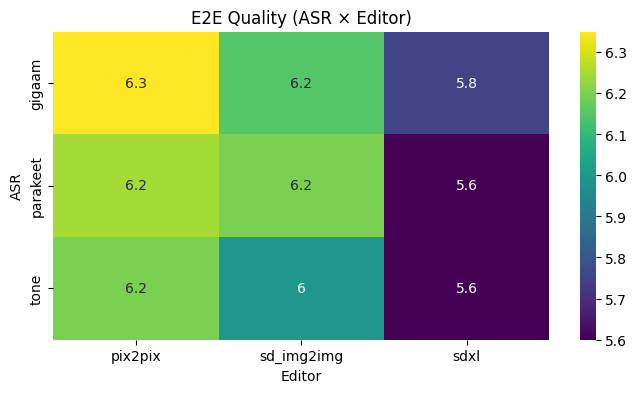

In [17]:
final_df = results_df.merge(semantic_df[['ASR', 'semantic_wer_mean']], on="ASR")
final_df["quality_score"] = final_df["e2e_score"] * (1.0 - final_df["semantic_wer_mean"])

display(final_df.sort_values("e2e_score", ascending=False))

pivot = final_df.pivot(index="ASR", columns="Editor", values="e2e_score")
plt.figure(figsize=(8, 4))
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("E2E Quality (ASR × Editor)")
plt.show()

In [22]:
for ed in editors.values():
    ed.close()
if DEVICE.startswith("cuda"):
    torch.cuda.empty_cache()